In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

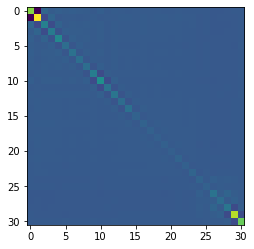

In [4]:
plt.imshow(syscov)


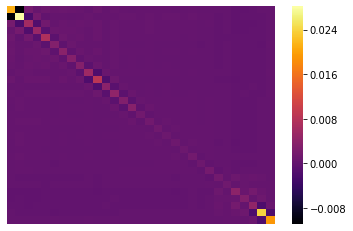

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(syscov), np.max(syscov) #checking non-negatives in the diagonal

(-0.01084098704, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 1000
# noise_factor1 = 1e-4
noise_factor1 = 1e-4
noise_factor2 = 0.1
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
    covset[i] = syscov  + noise_factor1 * err
    err = np.random.normal(size=syscov.shape) 
    covset_noise[i] = syscov  + noise_factor2 * err
#     fig = plt.figure(figsize=(6,6))
#     sns.heatmap(pd.DataFrame(pset[i]*maxval), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', cbar=False,
#             robust=False)
#     fig.savefig('image/covMatrix_{}.png'.format(i), dpi=300, )
#     plt.clf()

 Generating 1000 matrix 

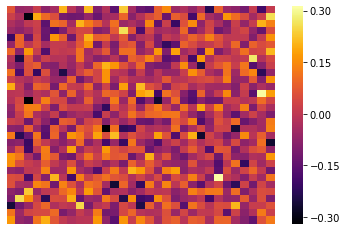

In [8]:
sns.heatmap(pd.DataFrame(covset_noise[1]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [9]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


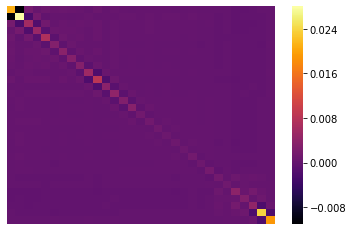

In [10]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [11]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(300, activation='tanh')(input_img)
x = layers.Dense(200, activation='tanh')(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)

#begin decoder
x = layers.Dense(200, activation='tanh')(encoded)
x = layers.Dense(300, activation='tanh')(x)
decoded = layers.Dense(31*31, activation='linear')(x)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 300)               288600    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 31)                6231      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               6400      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_5 (Dense)              (None, 961)              

In [12]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=300,
                batch_size=16,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/300
50/50 [==============================] - 0s 5ms/step - loss: 4.4952e-04 - val_loss: 2.7450e-05
Epoch 2/300
50/50 [==============================] - 0s 3ms/step - loss: 9.2191e-06 - val_loss: 7.8137e-06
Epoch 3/300
50/50 [==============================] - 0s 3ms/step - loss: 3.2720e-06 - val_loss: 4.1086e-06
Epoch 4/300
50/50 [==============================] - 0s 3ms/step - loss: 1.7239e-06 - val_loss: 2.4597e-06
Epoch 5/300
50/50 [==============================] - 0s 3ms/step - loss: 1.0151e-06 - val_loss: 1.5820e-06
Epoch 6/300
50/50 [==============================] - 0s 4ms/step - loss: 6.4698e-07 - val_loss: 1.0674e-06
Epoch 7/300
50/50 [==============================] - 0s 3ms/step - loss: 4.3889e-07 - val_loss: 7.5634e-07
Epoch 8/300
50/50 [==============================] - 0s 3ms/step - loss: 3.1181e-07 - val_loss: 5.5970e-07
Epoch 9/300
50/50 [==============================] - 0s 3ms/step - loss: 2.3263e-07 - val_loss: 4.1671e-07
Epoch 10/300
50/50 [=================

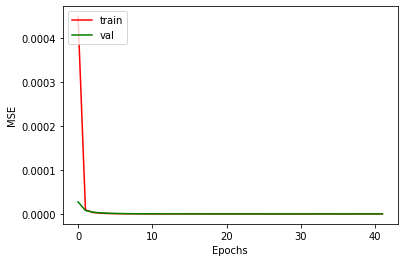

In [14]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [15]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

3.955835481406211e-08 3.413294180631965e-08


In [16]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
np.min(encoded_imgs)

(200, 31)


-0.026419612

(200, 961)


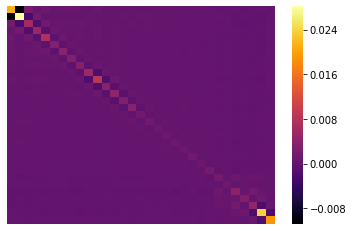

In [17]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [18]:
print(np.shape(decoded_imgs))

(200, 961)


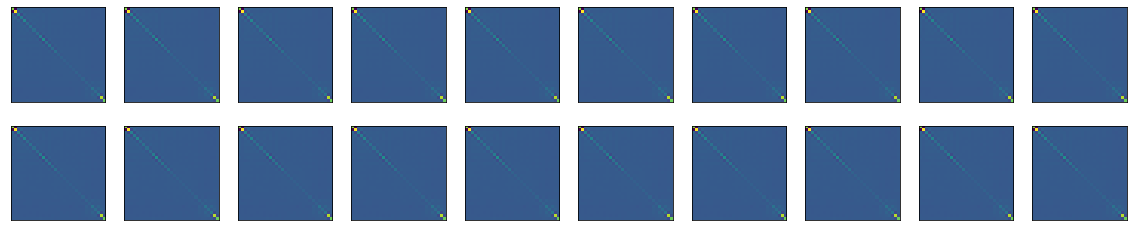

In [19]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

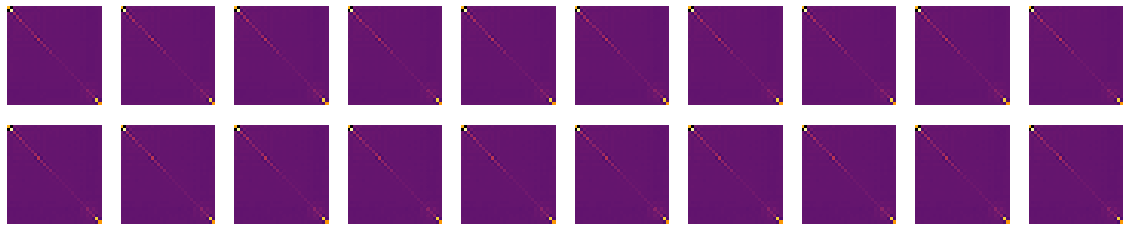

In [20]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

           z      $D_L$
0   0.010000  32.953887
1   0.011762  33.879003
2   0.013833  33.842141
3   0.016270  34.118567
4   0.019136  34.593446
5   0.022507  34.939027
6   0.026472  35.252096
7   0.031135  35.748502
8   0.036620  36.069788
9   0.043071  36.434570
10  0.050658  36.651111
11  0.059582  37.158014
12  0.070077  37.430173
13  0.082422  37.956616
14  0.096941  38.253254
15  0.114018  38.612869
16  0.134102  39.067851
17  0.157725  39.341402
18  0.185509  39.792144
19  0.218188  40.156535
20  0.256623  40.564956
21  0.301829  40.905288
22  0.354997  41.421417
23  0.417532  41.790923
24  0.491083  42.231461
25  0.577590  42.617047
26  0.679335  43.052731
27  0.799004  43.504151
28  0.939753  43.972573
29  1.105296  44.514088
30  1.300000  44.821867


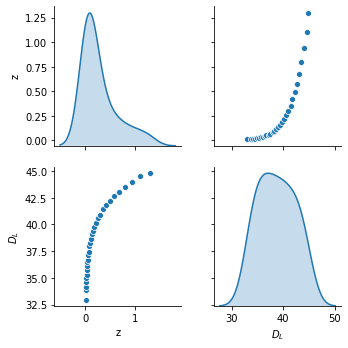

In [21]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [22]:
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
comp = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(comp)

data = data.values[shuffle]

In [23]:
z = data[:,0]
dl = data[:,1:]

In [24]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [25]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
dl_train, dl_test = np.split(dl, indx)

In [26]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.,
                                   patience=200,
                                   restore_best_weights=True)]

In [27]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(efirst)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 1
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_11 (Dense)             (None, 200)              

In [28]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test),
                                    callbacks=callbacks)

Epoch 1/500
24/24 [==============================] - 0s 5ms/step - loss: 1152.6200 - val_loss: 2364.3101
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 500.9852 - val_loss: 505.5334
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 308.9447 - val_loss: 246.7455
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 77.9943 - val_loss: 57.6146
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 36.0622 - val_loss: 60.9366
Epoch 6/500
24/24 [==============================] - 0s 1ms/step - loss: 18.9012 - val_loss: 21.0572
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 5.8189 - val_loss: 23.6706
Epoch 8/500
24/24 [==============================] - 0s 2ms/step - loss: 3.4735 - val_loss: 9.6789
Epoch 9/500
24/24 [==============================] - 0s 2ms/step - loss: 3.3890 - val_loss: 7.3477
Epoch 10/500
24/24 [==============================] - 0s 2ms/step - loss: 3.2705 - val_l

24/24 [==============================] - 0s 1ms/step - loss: 1.2977 - val_loss: 2.0252
Epoch 83/500
24/24 [==============================] - 0s 1ms/step - loss: 1.0595 - val_loss: 2.3003
Epoch 84/500
24/24 [==============================] - 0s 2ms/step - loss: 1.0563 - val_loss: 2.0709
Epoch 85/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4045 - val_loss: 1.4342
Epoch 86/500
24/24 [==============================] - 0s 2ms/step - loss: 0.8352 - val_loss: 0.9727
Epoch 87/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4773 - val_loss: 2.2491
Epoch 88/500
24/24 [==============================] - 0s 2ms/step - loss: 0.8877 - val_loss: 0.3340
Epoch 89/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5213 - val_loss: 0.2924
Epoch 90/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6361 - val_loss: 0.3704
Epoch 91/500
24/24 [==============================] - 0s 1ms/step - loss: 1.1259 - val_loss: 4.9148
Epoch 92/500


24/24 [==============================] - 0s 1ms/step - loss: 0.7184 - val_loss: 0.8555
Epoch 164/500
24/24 [==============================] - 0s 1ms/step - loss: 3.4488 - val_loss: 1.2111
Epoch 165/500
24/24 [==============================] - 0s 1ms/step - loss: 6.2129 - val_loss: 3.5238
Epoch 166/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2651 - val_loss: 0.4673
Epoch 167/500
24/24 [==============================] - 0s 1ms/step - loss: 1.3865 - val_loss: 0.5966
Epoch 168/500
24/24 [==============================] - 0s 1ms/step - loss: 0.9153 - val_loss: 0.0901
Epoch 169/500
24/24 [==============================] - 0s 1ms/step - loss: 1.4418 - val_loss: 0.1398
Epoch 170/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5603 - val_loss: 0.4413
Epoch 171/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5491 - val_loss: 0.0454
Epoch 172/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2555 - val_loss: 0.3681
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.3624 - val_loss: 1.4233
Epoch 245/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4999 - val_loss: 0.6086
Epoch 246/500
24/24 [==============================] - 0s 2ms/step - loss: 2.1871 - val_loss: 6.8976
Epoch 247/500
24/24 [==============================] - 0s 2ms/step - loss: 1.9236 - val_loss: 1.3018
Epoch 248/500
24/24 [==============================] - 0s 2ms/step - loss: 5.9854 - val_loss: 10.9907
Epoch 249/500
24/24 [==============================] - 0s 2ms/step - loss: 6.8465 - val_loss: 10.6851
Epoch 250/500
24/24 [==============================] - 0s 2ms/step - loss: 2.6896 - val_loss: 19.9591
Epoch 251/500
24/24 [==============================] - 0s 2ms/step - loss: 3.0369 - val_loss: 3.2245
Epoch 252/500
24/24 [==============================] - 0s 2ms/step - loss: 2.3433 - val_loss: 4.6116
Epoch 253/500
24/24 [==============================] - 0s 2ms/step - loss: 0.9360 - val_loss: 1.5844
E

24/24 [==============================] - 0s 1ms/step - loss: 0.6682 - val_loss: 2.1357
Epoch 326/500
24/24 [==============================] - 0s 1ms/step - loss: 1.1340 - val_loss: 0.0909
Epoch 327/500
24/24 [==============================] - 0s 1ms/step - loss: 0.6621 - val_loss: 0.1950
Epoch 328/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2947 - val_loss: 0.0571
Epoch 329/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3351 - val_loss: 0.1597
Epoch 330/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3083 - val_loss: 0.1724
Epoch 331/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3906 - val_loss: 0.0476
Epoch 332/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6305 - val_loss: 1.1933
Epoch 333/500
24/24 [==============================] - 0s 2ms/step - loss: 0.8526 - val_loss: 0.0470
Epoch 334/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2175 - val_loss: 0.3868
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 1.0961 - val_loss: 0.0162
Epoch 407/500
24/24 [==============================] - 0s 2ms/step - loss: 0.7710 - val_loss: 0.0535
Epoch 408/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4796 - val_loss: 3.9753
Epoch 409/500
24/24 [==============================] - 0s 2ms/step - loss: 1.0018 - val_loss: 0.6896
Epoch 410/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5128 - val_loss: 1.4510
Epoch 411/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3560 - val_loss: 1.1021
Epoch 412/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5662 - val_loss: 4.3493
Epoch 413/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5590 - val_loss: 0.2607
Epoch 414/500
24/24 [==============================] - 0s 1ms/step - loss: 0.4346 - val_loss: 0.0777
Epoch 415/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2910 - val_loss: 0.4439
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 0.4488 - val_loss: 1.4968
Epoch 488/500
24/24 [==============================] - 0s 2ms/step - loss: 0.2501 - val_loss: 0.4607
Epoch 489/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3147 - val_loss: 0.3308
Epoch 490/500
24/24 [==============================] - 0s 2ms/step - loss: 0.2623 - val_loss: 0.0351
Epoch 491/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4550 - val_loss: 0.7734
Epoch 492/500
24/24 [==============================] - 0s 2ms/step - loss: 1.2193 - val_loss: 2.1595
Epoch 493/500
24/24 [==============================] - 0s 2ms/step - loss: 0.8374 - val_loss: 4.1938
Epoch 494/500
24/24 [==============================] - 0s 2ms/step - loss: 0.8645 - val_loss: 3.4500
Epoch 495/500
24/24 [==============================] - 0s 2ms/step - loss: 0.7662 - val_loss: 0.0383
Epoch 496/500
24/24 [==============================] - 0s 2ms/step - loss: 0.2079 - val_loss: 0.0814
Epoc

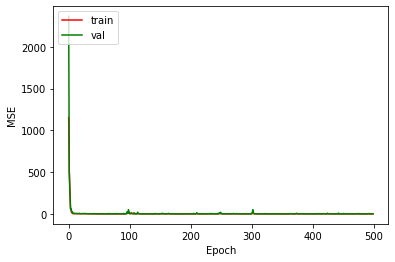

In [29]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [30]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])

(0.016214029863476753, 0.11364511400461197)

In [31]:
pred = neural_model.predict(z_test)
pred

array([[39.67618 ],
       [40.569183],
       [41.289482],
       [42.033623],
       [42.68305 ],
       [43.38596 ],
       [44.34846 ]], dtype=float32)

In [32]:
# ranz = np.random.uniform(0, np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z),31)

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranz)
pred_random

array([[34.543503],
       [37.24836 ],
       [38.567165],
       [39.077858],
       [39.631145],
       [40.18299 ],
       [40.694103],
       [41.00203 ],
       [41.283043],
       [41.56066 ],
       [41.83828 ],
       [42.004578],
       [42.159107],
       [42.31364 ],
       [42.468178],
       [42.61732 ],
       [42.73343 ],
       [42.849495],
       [42.965557],
       [43.08162 ],
       [43.19769 ],
       [43.31375 ],
       [43.429813],
       [43.54588 ],
       [43.66194 ],
       [43.778008],
       [43.894142],
       [44.011017],
       [44.12827 ],
       [44.240112],
       [44.34846 ]], dtype=float32)

In [33]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [34]:
fake_encoded = np.zeros((1, 31))

In [35]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [36]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[0, i] = alpha * ranz[i]

In [37]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake)

(1, 961)

In [38]:
decoded_fake[0, :]

array([ 2.12651994e-02, -1.09836143e-02,  1.96062191e-03,  7.31756329e-04,
        1.01957493e-03,  2.24816380e-04,  1.07754359e-03,  6.17932819e-04,
        5.62652363e-04,  8.78866995e-05,  7.32932996e-04, -6.37955964e-08,
        1.30418222e-04, -6.62850798e-05,  2.25836644e-04,  2.77845480e-04,
        5.13638137e-04,  2.07782839e-04,  5.64210815e-04,  6.24708657e-04,
       -1.54357404e-05,  5.44890703e-04, -1.55216112e-05,  4.42709774e-04,
       -3.20501684e-04,  3.61014507e-04, -5.79844345e-05, -4.69166553e-04,
       -3.11357027e-04,  8.99549923e-05,  1.76696805e-04, -1.08370520e-02,
        2.77137645e-02, -2.62405537e-03,  1.52462139e-03, -1.51651911e-05,
        2.68684700e-04,  3.11829965e-04,  4.97604022e-04,  2.85893591e-04,
        7.18670024e-04,  1.74111570e-04,  4.06697945e-04,  4.61487420e-04,
        5.21731446e-04,  5.37968415e-04,  9.00712679e-04,  5.80519321e-04,
        4.61981021e-04,  2.75425264e-04,  4.25501581e-04,  1.34076559e-04,
        1.21448189e-04,  

6.3795596e-08

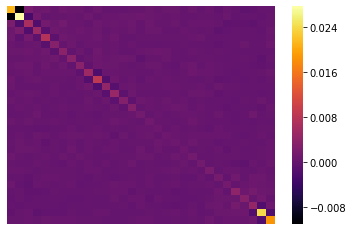

In [39]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.010983614 0.027713764 0.000376776
-0.010789442 0.028166154 0.00041277692


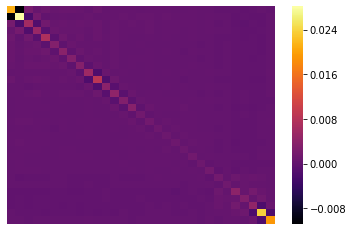

In [40]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [41]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [42]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
            print(i,j, end=' ')
            print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

0 1 -0.010983614 -0.010837052
0 2 0.001960622 0.0020707366
0 3 0.0007317563 0.0007019142
0 4 0.0010195749 0.0010535975
0 5 0.00022481638 0.0004646918
0 6 0.0010775436 0.0005449889
0 7 0.0006179328 0.0002256902
0 8 0.00056265236 0.00047637586
0 9 8.78867e-05 0.00022497663
0 10 0.000732933 0.0008364198
0 11 -6.3795596e-08 0.00059034687
0 12 0.00013041822 0.00015251
0 13 -6.628508e-05 0.0005284144
0 14 0.00022583664 0.00014127017
0 15 0.00027784548 -9.0736736e-05
0 16 0.00051363814 0.0005768798
0 17 0.00020778284 -9.7791664e-05
0 18 0.0005642108 8.634874e-05
0 19 0.00062470866 0.00020659222
0 20 -1.543574e-05 0.000118406286
0 21 0.0005448907 0.0008042841
0 22 -1.5521611e-05 0.00029823615
0 23 0.00044270977 0.00040144293
0 24 -0.00032050168 8.293602e-06
0 25 0.0003610145 0.0007730605
0 26 -5.7984435e-05 -4.558306e-05
0 27 -0.00046916655 -0.0001171421
0 28 -0.00031135703 6.7346e-05
0 29 8.995499e-05 -0.00033048724
0 30 0.0001766968 0.00032994896
1 2 -0.0026240554 -0.0019284955
1 3 0.0015246

465

In [43]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

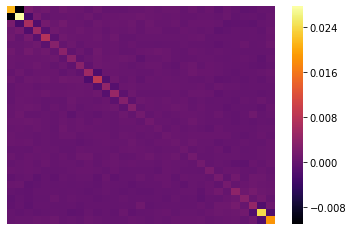

In [44]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [45]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)


np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")
fake_data


array([[1.00000000e-02, 3.45435028e+01],
       [5.30000000e-02, 3.72483597e+01],
       [9.60000000e-02, 3.85671654e+01],
       [1.39000000e-01, 3.90778580e+01],
       [1.82000000e-01, 3.96311455e+01],
       [2.25000000e-01, 4.01829910e+01],
       [2.68000000e-01, 4.06941032e+01],
       [3.11000000e-01, 4.10020294e+01],
       [3.54000000e-01, 4.12830429e+01],
       [3.97000000e-01, 4.15606613e+01],
       [4.40000000e-01, 4.18382797e+01],
       [4.83000000e-01, 4.20045776e+01],
       [5.26000000e-01, 4.21591072e+01],
       [5.69000000e-01, 4.23136406e+01],
       [6.12000000e-01, 4.24681778e+01],
       [6.55000000e-01, 4.26173210e+01],
       [6.98000000e-01, 4.27334290e+01],
       [7.41000000e-01, 4.28494949e+01],
       [7.84000000e-01, 4.29655571e+01],
       [8.27000000e-01, 4.30816193e+01],
       [8.70000000e-01, 4.31976891e+01],
       [9.13000000e-01, 4.33137512e+01],
       [9.56000000e-01, 4.34298134e+01],
       [9.99000000e-01, 4.35458794e+01],
       [1.042000

In [46]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(clean_img.reshape(31,31))))

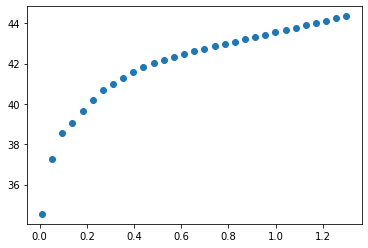

In [47]:
plt.scatter(ranz, pred_random)

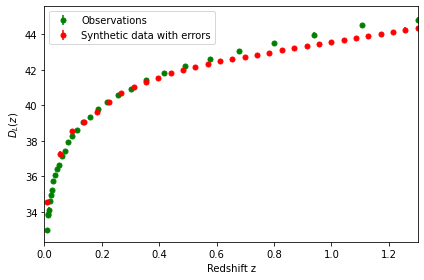

In [48]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
plt.savefig('fake_vs_binned_jla.png', dpi=200)

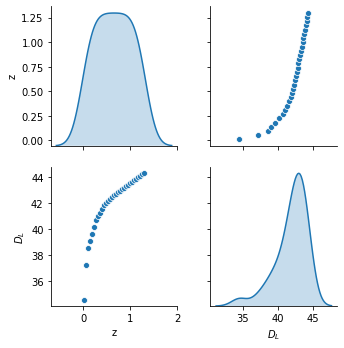

In [49]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')